In [ ]:
### 0. Import relevant libraries
import sklearn as sk #type: ignore
import numpy as np #type: ignore
import pandas as pd #type: ignore
from matplotlib import pyplot as plt #type: ignore

from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd  # type: ignore
import tensorflow as tf  # type: ignore

# from A_data_loader import A_data_loader_main # returns data as DataFrame, preprocessed, ready for tensor creation
# from requirements import train_begin_date, train_cutoff_date, validation_begin_date 
# from requirements import validation_cutoff_date, test_begin_date, test_cutoff_date 

In [8]:
### 1. Data Loading
def load_data(file_path):
    try:
        data = pd.read_parquet(file_path)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
    return data
file_path = '/Users/imarcolic/Desktop/1 ACADEMIA/20 MSc LSE/1 MSc Data Science/' \
    'ST498 Capstone/1 Data/5km_resolution_with_missing_data_handled_2022_to_2025.parquet'
data = load_data(file_path)

print(data.head())
print(data.tail())

   lat_5km  lon_5km     KD490        ZSD  RRS490  RRS443       CHL  MICRO  \
0    49.15   -10.75  0.035727  26.936846    -2.0    -2.0  0.124980   -2.0   
1    49.15   -10.70  0.035727  26.936848    -2.0    -2.0  0.124980   -2.0   
2    49.15   -10.65  0.035787  26.878199    -2.0    -2.0  0.125559   -2.0   
3    49.15   -10.60  0.035876  26.790228    -2.0    -2.0  0.126427   -2.0   
4    49.15   -10.55  0.035876  26.790228    -2.0    -2.0  0.126427   -2.0   

   BBP  CDM       time  flags        date  
0 -2.0 -2.0 2025-01-01    0.0  2025-01-01  
1 -2.0 -2.0 2025-01-01    0.0  2025-01-01  
2 -2.0 -2.0 2025-01-01    0.0  2025-01-01  
3 -2.0 -2.0 2025-01-01    0.0  2025-01-01  
4 -2.0 -2.0 2025-01-01    0.0  2025-01-01  
          lat_5km  lon_5km  KD490  ZSD  RRS490  RRS443  CHL  MICRO  BBP  CDM  \
14146897    52.25    -2.35   -1.0 -1.0    -1.0    -1.0 -1.0   -1.0 -1.0 -1.0   
14146898    52.25    -2.30   -1.0 -1.0    -1.0    -1.0 -1.0   -1.0 -1.0 -1.0   
14146899    52.25    -2.25   -1.0

In [9]:
### 2. Data 
def inspect_data(data):
    print("\nData Inspection:")
    if data is None:
        print("No data detected")
    else:
        print(f"Shape: {data.shape}")
        print(f"Unique Values in time: {data['time'].nunique()}")
        print(f"Unique Values in lat: {data['lat_5km'].nunique()}")
        print(f"Unique Values in lon: {data['lon_5km'].nunique()}")
        print(f"Unique values in flags: {data['flags'].nunique()}")

        
inspect_data(data)


Data Inspection:
Shape: (14146902, 13)
Unique Values in time: 1298
Unique Values in lat: 63
Unique Values in lon: 173
Unique values in flags: 2


In [10]:
### 3. Date Checking
def check_nan_dates(data):
    print("\nChecking for NaN dates:")
    variables_list = data.iloc[:, 2:10]
    # Check how many entries there are
    print(f"Total number of entries: {len(data)}")

    # Check "-2" values in each variable
    counting_bad_values = pd.DataFrame(columns=["Variable", "Count"])
    for variable in variables_list:
        count = (data[variable] == -2).sum()
        counting_bad_values.loc[len(counting_bad_values)] = [variable, count]
    print(counting_bad_values)

check_nan_dates(data)


Checking for NaN dates:
Total number of entries: 14146902
  Variable    Count
0    KD490        0
1      ZSD        0
2   RRS490  1626269
3   RRS443  1626269
4      CHL        0
5    MICRO  2068719
6      BBP  1856343
7      CDM  1856343


In [11]:
### 4. Restacking data
def restack_data(data):
    print("\nRestacking Data:")
    # Change type of date column to datetime then to integer
    data["date"] = pd.to_datetime(data["date"])

    # Make a copy of all rows in dataframe which occur from the 2025-01-01 onwards
    # Find the index of the first occurrence of the date 2022-01-01
    first_index = data[data["date"] == "2022-01-01"].index[0]
    restacked_data = data[:first_index].copy()
    print("Cut out rows:")
    print(restacked_data.head())

    # Drop year 2025 rows from the original DataFrame
    data = data.drop(index=data.index[:first_index])
    print("Clean data without 2025 rows:")
    print(data.head())

    # Amend the restacked rows to the end of the original data dataframe
    data = pd.concat([data, restacked_data], ignore_index=True)

    # Change date column to integer format
    data["date"] = data["date"].dt.strftime('%Y%m%d').astype(int)

    print("\nRestacked Data complete:")
    print(data.head())
    print(data.tail())
    return data

data = restack_data(data)


Restacking Data:
Cut out rows:
   lat_5km  lon_5km     KD490        ZSD  RRS490  RRS443       CHL  MICRO  \
0    49.15   -10.75  0.035727  26.936846    -2.0    -2.0  0.124980   -2.0   
1    49.15   -10.70  0.035727  26.936848    -2.0    -2.0  0.124980   -2.0   
2    49.15   -10.65  0.035787  26.878199    -2.0    -2.0  0.125559   -2.0   
3    49.15   -10.60  0.035876  26.790228    -2.0    -2.0  0.126427   -2.0   
4    49.15   -10.55  0.035876  26.790228    -2.0    -2.0  0.126427   -2.0   

   BBP  CDM       time  flags       date  
0 -2.0 -2.0 2025-01-01    0.0 2025-01-01  
1 -2.0 -2.0 2025-01-01    0.0 2025-01-01  
2 -2.0 -2.0 2025-01-01    0.0 2025-01-01  
3 -2.0 -2.0 2025-01-01    0.0 2025-01-01  
4 -2.0 -2.0 2025-01-01    0.0 2025-01-01  
Clean data without 2025 rows:
         lat_5km  lon_5km     KD490        ZSD  RRS490  RRS443       CHL  \
2201598    49.15   -10.75  0.049010  18.180674    -2.0    -2.0  0.274246   
2201599    49.15   -10.70  0.048420  18.440617    -2.0    -2.0  0

In [12]:
### 1. Tensor Creation
def create_tensor(data):
    print("\nCreating Tensor:")
    # Get dimension shape
    n_date = data["date"].nunique()  # Number of unique days
    n_lat = data["lat_5km"].nunique() # Number of unique latitudes
    n_lon = data["lon_5km"].nunique()  # Number of unique longitudes
    n_variables = data.columns[2:10].nunique()  # Number of variables (excluding 'date', 'lat_5km', 'lon_5km', 'flags')

    # Create a 4D tensor with the shape (n_days, n_lat, n_lon, n_variables)
    tensor_shape = (n_date, n_lat, n_lon, n_variables)
    tensor = np.zeros(tensor_shape)
    print(f"Tensor shape: {tensor_shape}")

    # List of all unique dates, longitudes, and latitudes
    unique_dates = data["date"].unique()
    unique_lons = data["lon_5km"].unique()
    unique_lats = data["lat_5km"].unique()
    print(unique_dates)

    # Channel variable order: KD490, ZSD, RRS490, RRS443, CHL, MICRO, BBP, CDM
    variable_order = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']

    # Define function which fills in first dimension with values of all unique days 
    dic_dates = {}
    for i, date in enumerate(unique_dates):
        dic_dates[date] = i
    dic_lats = {}
    # !!! ATTENTION: Latitudes are flipped to match the tensor's indexing
    unique_lats = np.flip(unique_lats)
    for i, lat in enumerate(unique_lats):
        dic_lats[lat] = i
    dic_lons = {}
    for i, lon in enumerate(unique_lons):
        dic_lons[lon] = i

    # Map dates, lats, and lons to their indices
    data["date_idx"] = data["date"].map(dic_dates)
    data["lat_idx"] = data["lat_5km"].map(dic_lats)
    data["lon_idx"] = data["lon_5km"].map(dic_lons)

    # Initialize the progress bar
    with tqdm(total=100, desc="Filling Tensor", unit="percent") as pbar:
        # Total number of rows to process
        total_rows = len(data)
        processed_rows = 0
        update_interval = total_rows // 100  # Update every 1%

        # Iterate over the variables and populate the tensor
        for i, variable in enumerate(variable_order):
            # Extract the relevant data for the current variable
            variable_data = data[["date_idx", "lat_idx", "lon_idx", variable]].dropna()

            # Use NumPy advanced indexing to populate the tensor
            tensor[
                variable_data["date_idx"].values,
                variable_data["lat_idx"].values,
                variable_data["lon_idx"].values,
                i
            ] = variable_data[variable].values

            # Update progress bar
            processed_rows += len(variable_data)
            if processed_rows // update_interval > pbar.n:
                pbar.update(processed_rows // update_interval - pbar.n)
    return tensor, dic_dates, variable_order
tensor, dic_dates, variable_order = create_tensor(data)


Creating Tensor:
Tensor shape: (1298, 63, 173, 8)
[20220101 20220102 20220103 ... 20250719 20250720 20250721]


Filling Tensor: 800percent [00:03, 201.68percent/s]                    


In [13]:
### 2. Tensor Inspection
def inspect_tensor(tensor):
    print("\nTensor Inspection:")
    print(f"Shape: {tensor.shape}")
    print(f"Total number of elements: {tensor.size}")
    print(f"Number of dimensions: {tensor.ndim}")
    print(f"Data type: {tensor.dtype}")

    # Check for NaN values
    nan_count = np.isnan(tensor).sum()
    if nan_count > 0:
        print(f"Number of NaN values in tensor: {nan_count}")
    else:
        print("No NaN values in tensor.")
inspect_tensor(tensor)


Tensor Inspection:
Shape: (1298, 63, 173, 8)
Total number of elements: 113175216
Number of dimensions: 4
Data type: float64
No NaN values in tensor.



Visualizing Tensor:


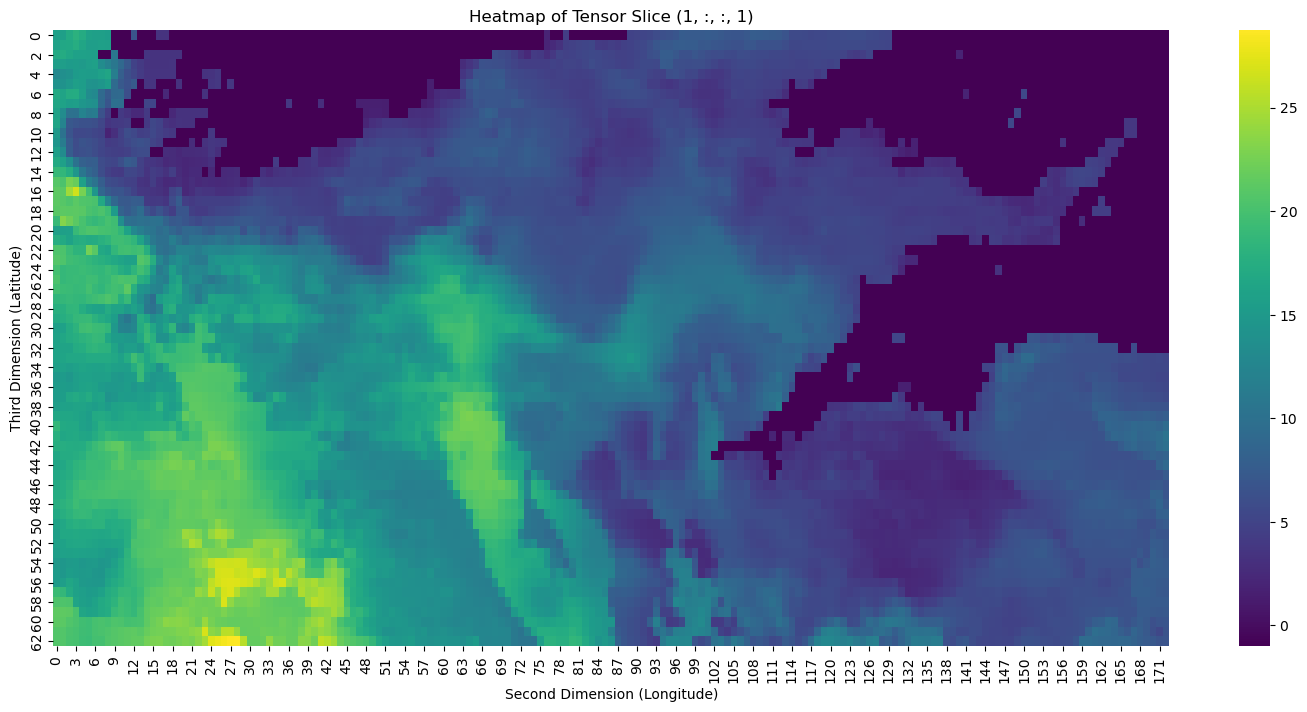

In [78]:
### 3. Tensor Visualization
def visualize_tensor(tensor):
    print("\nVisualizing Tensor:")
    # Plot a heatmap for the second and third dimensions of the tensor
    tensor_slice = tensor[200, :, :, 1]

    # Create a heatmap
    plt.figure(figsize=(18, 8))
    sns.heatmap(tensor_slice, cmap="viridis", cbar=True)
    plt.title("Heatmap of Tensor Slice (1, :, :, 1)")
    plt.xlabel("Second Dimension (Longitude)")
    plt.ylabel("Third Dimension (Latitude)")
    plt.show()
visualize_tensor(tensor)



In [15]:
### 3.1 Getting Valid Dates for Training, Validation, and Testing

def get_valid_dates(tensor, variable_order):
    print("\nGetting valid dates for training, validation, and testing:")
    
    # Initialize a dictionary to store results
    results = {var: {"Count": 0, "Date Indexes as List": []} for var in variable_order}
    
    # Loop over dates and variables
    for date in tqdm(range(tensor.shape[0])):  # Assuming 0th dimension is date
        for var_idx, var_name in enumerate(variable_order):  # Loop over variables
            # Slice the tensor for the current date and variable
            slice_2d = tensor[date, :, :, var_idx]
            
            # Check if there's at least one -2 in the slice
            if np.any(slice_2d == -2):
                results[var_name]["Count"] += 1
                results[var_name]["Date Indexes as List"].append(date)
    
    # Convert results to a DataFrame
    valid_dates = pd.DataFrame.from_dict(results, orient="index").reset_index()
    valid_dates.rename(columns={"index": "Variable"}, inplace=True)
    
    print(valid_dates)
    return valid_dates
valid_dates = get_valid_dates(tensor, variable_order)




Getting valid dates for training, validation, and testing:


100%|██████████| 1298/1298 [00:00<00:00, 3136.07it/s]

  Variable  Count                               Date Indexes as List
0    KD490      0                                                 []
1      ZSD      0                                                 []
2   RRS490    181  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
3   RRS443    181  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
4      CHL      0                                                 []
5    MICRO    231  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
6      BBP    207  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
7      CDM    207  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...


In [ ]:
### Create mask for NaN -2 values
def add_masks(tensor):
    # Create a mask for NaN values (-2)
    print("\nCreating masks for NaN -2 values:")
    nan_mask = tf.cast(tf.not_equal(tensor, -2), dtype=tf.float32)
    print(f"NaN mask shape: {nan_mask.shape}")

    # Create a mask for land values (-1)
    print("\nCreating land mask:")
    land_mask = tf.cast(tf.equal(tensor, -1), dtype=tf.float32)
    print(f"Land mask shape: {land_mask.shape}")

    clean_tensor = tf.concat([tensor, nan_mask, land_mask], axis=-1)
    print(f"Clean tensor shape after adding masks: {clean_tensor.shape}")

    clean_tensor = tf.cast(clean_tensor, dtype=tf.float32)
    return clean_tensor, nan_mask, land_mask
clean_tensor, nan_mask, land_mask = add_masks(tensor)
#np.save("land_mask.npy", land_mask.numpy())


Creating masks for NaN -2 values:
NaN mask shape: (1298, 63, 173, 8)

Creating land mask:
Land mask shape: (1298, 63, 173, 8)
Clean tensor shape after adding masks: (1298, 63, 173, 24)


In [ ]:
### 4. Splitting Tensor into Training, Validation, and Test Sets

# Arbitrary set dates for training, validation, and test sets - format: YYYYMMDD - including all dates
train_begin_date = 20220101
train_cutoff_date = 20231231
validation_begin_date = 20240101
validation_cutoff_date = 20240731
test_begin_date = 20240801
test_cutoff_date = 20250721

def split_tensor(clean_tensor, dic_dates):
    # Arbitrary set Training, validation, test dates, due to Winter dates inavailability
    train_begin_index = dic_dates[train_begin_date]
    train_cutoff_index = dic_dates[train_cutoff_date]

    validation_begin_index = dic_dates[validation_begin_date]
    validation_cutoff_index = dic_dates[validation_cutoff_date]

    test_begin_index = dic_dates[test_begin_date]
    test_cutoff_index = dic_dates[test_cutoff_date]

    # Split the tensor into training, validation, and test sets
    train_tensor = clean_tensor[train_begin_index:train_cutoff_index, : , : , :]
    validation_tensor = clean_tensor[validation_begin_index:validation_cutoff_index, : , : , :]
    test_tensor = clean_tensor[test_begin_index:test_cutoff_index, :, :, :]

    print(f"Tensor shapes after splitting:")
    print(f"Training tensor shape: {train_tensor.shape}")
    print(f"Validation tensor shape: {validation_tensor.shape}")
    print(f"Test tensor shape: {test_tensor.shape}")
    return train_tensor, validation_tensor, test_tensor
train_tensor, validation_tensor, test_tensor = split_tensor(clean_tensor, dic_dates)

Tensor shapes after splitting:
Training tensor shape: (729, 63, 173, 24)
Validation tensor shape: (212, 63, 173, 24)
Test tensor shape: (354, 63, 173, 24)


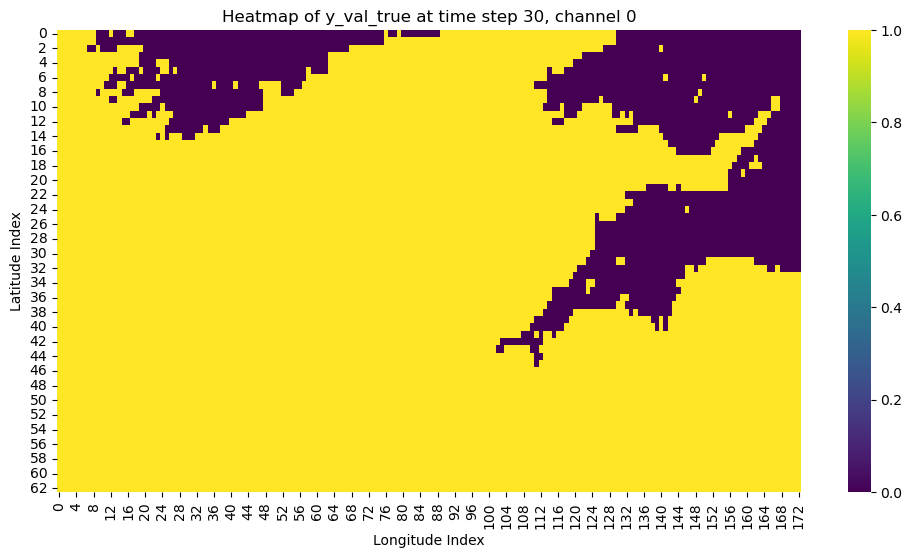

In [64]:
# Invert the values in land_mask: 0 becomes 1, 1 becomes 0
land_mask = 1 - land_mask
plt.figure(figsize=(12, 6))
sns.heatmap(land_mask[30, :, :, 0].numpy(), cmap="viridis", cbar=True)
plt.title("Heatmap of y_val_true at time step 30, channel 0")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()

In [75]:
train_tensor = train_tensor[:, :, :, :8] * land_mask[:train_tensor.shape[0], :, :, :8]  # Zero out land values
validation_tensor = validation_tensor[:, :, :, :8] * land_mask[:validation_tensor.shape[0], :, :, :8]
test_tensor = test_tensor[:, :, :, :8] * land_mask[:test_tensor.shape[0], :, :, :8]

TypeError: 'NoneType' object is not subscriptable

In [73]:
# ONLY SAVE TENSORS IF THEY ARE NOT ALREADY SAVED
train_tensor = np.save("train_tensor.npy", train_tensor)
validation_tensor = np.save("validation_tensor.npy", validation_tensor)
test_tensor = np.save("test_tensor.npy", test_tensor)

---

In [57]:
T = 1  # Number of time steps to look back
features = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']

In [62]:
def create_shifted_frames(data, T, target_channels):
    N, H, W, C = data.shape
    n_samples = N - T

    x = np.zeros((n_samples, T, H, W, C), dtype=np.float32)
    y = np.zeros((n_samples, H, W, target_channels), dtype=np.float32)

    for i in range(n_samples):
        x[i] = data[i:i + T]
        y[i] = data[i + T, :, :, :target_channels]
    return x, y
x_train, y_train = create_shifted_frames(train_tensor, T, target_channels=8)
x_val, y_val = create_shifted_frames(validation_tensor, T, target_channels=8)
y_val_true = y_val.copy() 

In [63]:
print("y_val_true shape:", y_val_true.shape)
print("land_mask shape:", land_mask.shape)
print("land_mask sliced shape:", land_mask[:211, :, :, :].shape)

y_val_true shape: (211, 63, 173, 8)
land_mask shape: (1298, 63, 173, 8)
land_mask sliced shape: (211, 63, 173, 8)


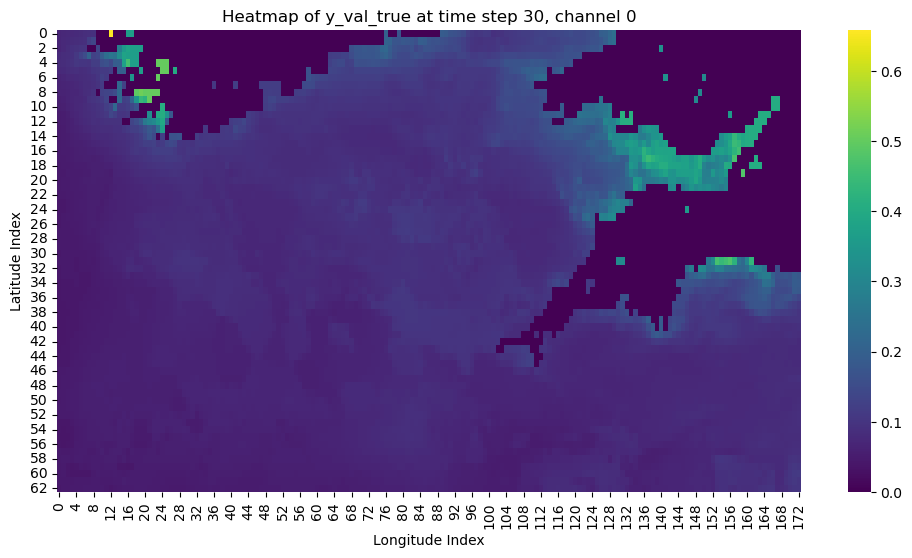

In [65]:
y_val_true = y_val_true * land_mask[:211, :, :, :]  # Zero out land values
plt.figure(figsize=(12, 6))
sns.heatmap(y_val_true[30, :, :, 0].numpy(), cmap="viridis", cbar=True)
plt.title("Heatmap of y_val_true at time step 30, channel 0")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()

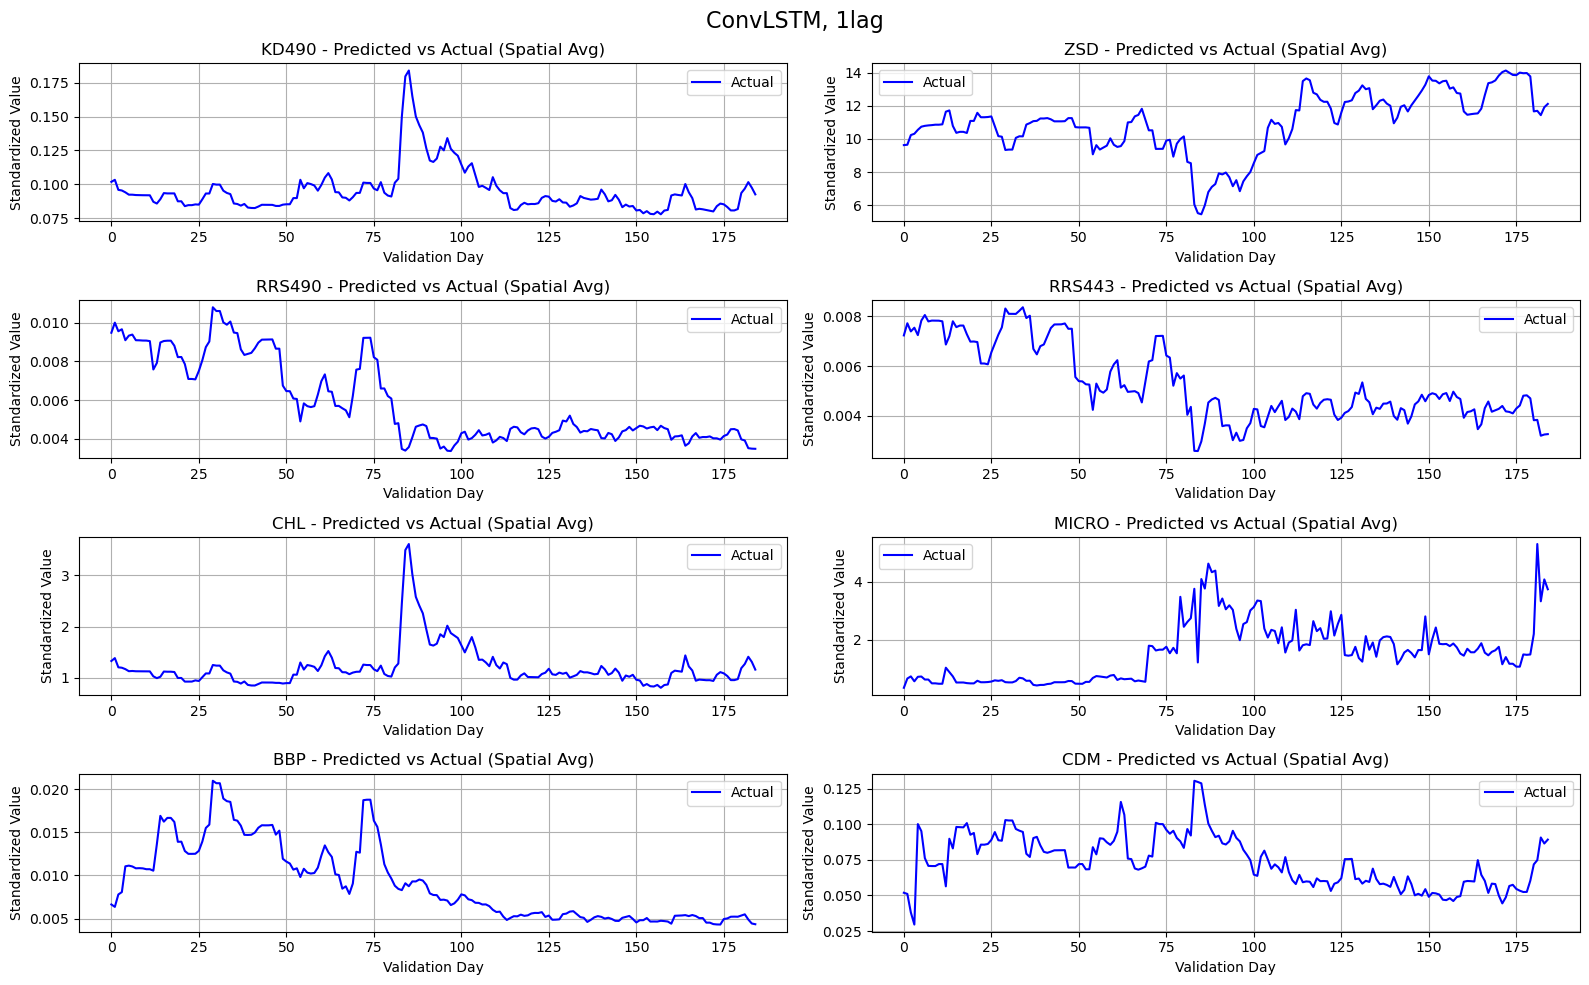

Figure(1600x1000)


In [ ]:
### 4. Evaluation
features = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']

# Comparison Graphs
def plot_validation_true_graphs(y_val_true, features):
    fig, axs = plt.subplots(4, 2, figsize=(16, 10))
    fig.suptitle("ConvLSTM, 1lag", fontsize=16)
    axs = axs.flatten()
    days = np.arange(len(y_val_true)-26)  # days in validation period

    for i, var in enumerate(features):
    # Compute mean only over valid (non-zero) values
        valid = y_val_true[26:, :, :, i] != 0
        actual = np.where(valid, y_val_true[26:, :, :, i], np.nan)
        mean_actual = np.nanmean(actual, axis=(1, 2))
        axs[i].plot(days, mean_actual, label='Actual', color='blue')
        axs[i].set_title(f"{var} - Predicted vs Actual (Spatial Avg)")
        axs[i].set_xlabel("Validation Day")
        axs[i].set_ylabel("Standardized Value")
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()  

    return fig
print(plot_validation_true_graphs(y_val_true, features))

In [ ]:
print(plot_validation_true_graphs(y_val_true, features))

In [ ]:
# Heatmap of metrics
mape = np.mean(np.abs((y_val_pred - y_val_true) / (y_val_true + 1e-8)), axis=(0, 1, 2))
rmse = np.sqrt(np.mean((y_val_pred - y_val_true) ** 2, axis=(0, 1, 2)))
mae = np.mean(np.abs(y_val_pred - y_val_true), axis=(0, 1, 2))
metrics_df = pd.DataFrame({'MAPE': mape, 'RMSE': rmse, 'MAE': mae}, index=features).T

plt.figure(figsize=(12, 4))
sns.heatmap(metrics_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Error'})
plt.title("ConvLSTM (1-Day Forecast, 1lag, ) - Global Metrics per Variable (Validation Set)")
plt.xlabel("Variable")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()